In [8]:
from math import lgamma

In [2]:
%pylab inline

from functools import lru_cache
import sympy as sp
sp.init_printing()

N = sp.Symbol('N', positive=True, integer=True)
K = sp.Symbol('K', positive=True, integer=True)

Populating the interactive namespace from numpy and matplotlib


In [3]:
def nCr(n, k):
    return lgamma(n + 1) - lgamma(k + 1) - lgamma(n - k + 1)

@lru_cache(None)
def reg2(N):
    logn = log(N)
    return sum(exp(nCr(N, m) + m * (log(m) - logn) + (N - m) * (log(N - m) - logn)) for m in range(1, N)) + 2

@lru_cache(None)
def logreg(N, K):
    if K == 1:
        return 0
    elif K == 2:
        return log(reg2(N))
    a = logreg(N, 1)
    b = logreg(N, 2)
    for k in range(3, K + 1):
        q = log(N) - log(k - 2) + a
        x0 = min(q, b)
        x1 = max(q, b)
        c = x1 + log1p(exp(x0 - x1))
        a, b = b, c
    return c

In [4]:
def szpankowski(N, K):
    a = (K - 1) / 2 * log(N / 2)
    b = 1/2 * log(pi) - lgamma(K / 2)
    c = exp(lgamma(K / 2) + log(K) - log(3) - lgamma((K - 1) / 2) + 1/2 * log(2 / N))
    d = (3 + K * (K - 2) * (2 * K + 1)) / (36 * N)
    e = -exp(2 * lgamma(K / 2) + 2 * log(K) - log(9) - 2 * lgamma((K - 1) / 2) - log(N))
    return a + b + c + d + e

In [5]:
def diff_szpankowski(N, K, r):
    log2_N_plus_1_9N = log(2.0/N) + 1./(9.0*N)
    sqrt18N = sqrt(18*N)

    K_2 = K/2
    Kr  = K*r
    logr = log(r)

    k = (Kr/2-K_2)*log2_N_plus_1_9N
    apx3 = (5*logr + log((Kr+1)/(K+1)))/12
    tidyramad = (K_2)*((r-1)*log(K_2)+r*logr+1 - r)
    klogk = tidyramad + apx3

    k3_2 = ((1-Kr)*sqrt(2*Kr +1) + (K-1)*sqrt(2*K+1))/sqrt18N
    return k - logr + k3_2 + klogk

Szpankowski is accurate when $N$ is large compared to $K$:

In [9]:
logreg(100, 5)

In [10]:
szpankowski(100, 5)

Same with the difference, and the approximation for the difference is also pretty good:

In [11]:
logreg(100, 5) - logreg(100, 25)

In [12]:
szpankowski(100, 5) - szpankowski(100, 25) 

In [13]:
diff_szpankowski(100, 5, 5)

Things start to not go so well when $K$ is large compared to $N$:

In [14]:
logreg(50, 250)

In [15]:
szpankowski(50, 250)

In [16]:
logreg(100, 1000)

In [17]:
szpankowski(100, 1000)

Exact regret and the szpankowski approximation plotted as a function of $K$ with $r = 5$:

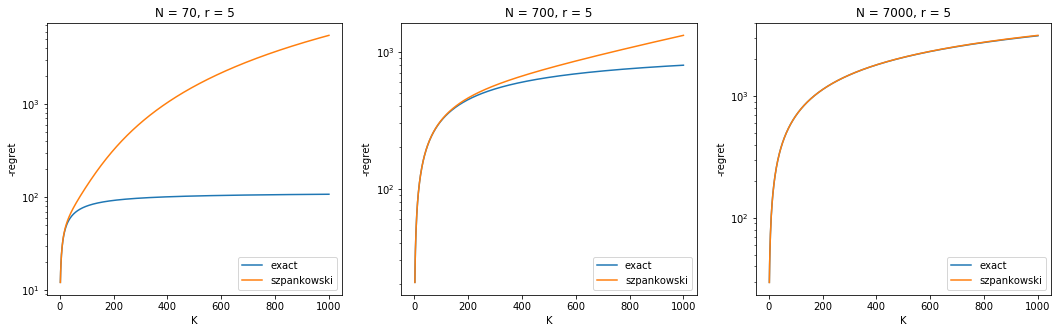

In [18]:
ldiff = lambda N, K, r: logreg(N, K) - logreg(N, K * r)

def plot_reg_K(n, r, ax):
    Y1 = [-ldiff(n, m, r) for m in range(2, 1001)]
    Y2 = [-diff_szpankowski(n, m, r) for m in range(2, 1001)]
    ax.set_title('N = %d, r = %d' % (n, r))
    ax.set_xlabel('K')
    ax.set_ylabel('-regret')
    ax.set_yscale('log')
    ax.plot(range(2, 1001), Y1, label='exact')
    ax.plot(range(2, 1001), Y2, label='szpankowski')
    ax.legend(loc=4)

pylab.rcParams['figure.figsize'] = (18, 5)
fig, axs = subplots(1, 3)
plot_reg_K(70, 5, axs[0])
plot_reg_K(700, 5, axs[1])
plot_reg_K(7000, 5, axs[2])
show()

As a function of $r$:

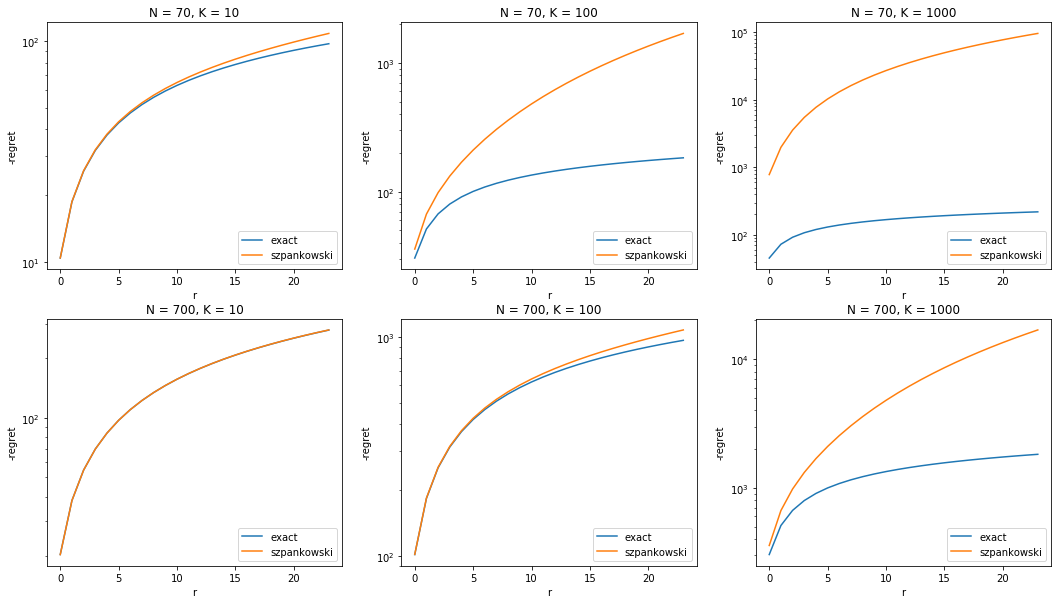

In [19]:
def plot_reg_r(n, m, ax):
    Y1 = [-ldiff(n, m, r) for r in range(2, 26)]
    Y2 = [-diff_szpankowski(n, m, r) for r in range(2, 26)]

    ax.plot(Y1, label='exact')
    ax.plot(Y2, label='szpankowski')
    ax.set_title('N = %d, K = %d' % (n, m))
    ax.set_xlabel('r')
    ax.set_ylabel('-regret')
    ax.set_yscale('log')
    ax.legend(loc=4)

pylab.rcParams['figure.figsize'] = (18, 10)
fig, axs = subplots(2, 3)
plot_reg_r(70, 10, axs[0][0])
plot_reg_r(70, 100, axs[0][1])
plot_reg_r(70, 1000, axs[0][2])
plot_reg_r(700, 10, axs[1][0])
plot_reg_r(700, 100, axs[1][1])
plot_reg_r(700, 1000, axs[1][2])
show()

The problem is that the Szpankowski approximation applies only for the case $ K = o(N) $. This is a problem in qNML as $N$ is likely to be small and $K$ can be huge. In https://pdfs.semanticscholar.org/8d11/1c02dc105fce8df5bf63ce474fe4e1092ffc.pdf it is proved that when $ N = o(K) $, the regret is asymptotically given by

$$ d_{N, K} = N \log{\frac{K}{N}} + \frac{3}{2} \frac{N(N - 1)}{K} + O\left(\frac{1}{\sqrt{N}} + \frac{N^3}{K^2}\right) $$

Thus in the case $ N = o(K) $ we can approximate the difference $d_{N, K} - d_{N, K r}$ by
$$ d_{N, K} - d_{N, K r} = N \left( \frac{3}{2} \frac{(N - 1)(r - 1)}{K r} - \log{r}\right) $$

In [20]:
def diff_approx(N, K, r):
    return N * (3 * (N - 1) * (r - 1) / (2 * K * r) - log(r))

def approx(N, K):
    return N * log(K / N) + 3 / 2 * N * (N - 1) / K

This is much more accurate when $K$ is large compared to $N$:

In [21]:
logreg(100, 1000)

In [22]:
szpankowski(100, 1000)

In [23]:
approx(100, 1000)

In [24]:
logreg(70, 350) - logreg(70, 3500)

In [25]:
diff_szpankowski(70, 350, 10)

In [26]:
diff_approx(70, 350, 10)

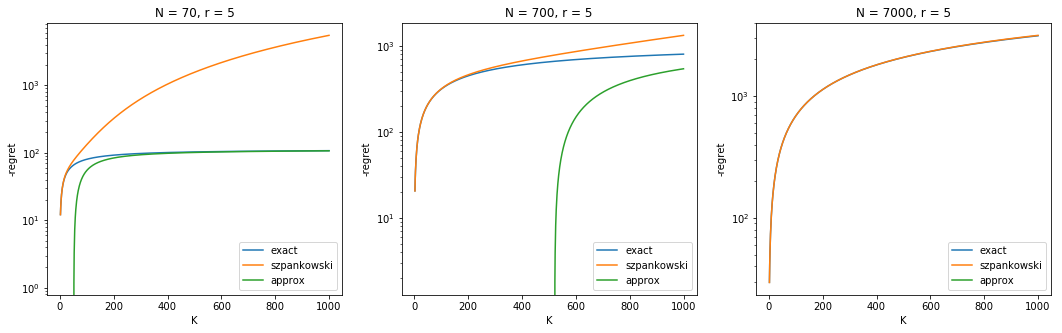

In [27]:
def plot_reg_K(n, r, ax):
    Y1 = [-ldiff(n, m, r) for m in range(2, 1001)]
    Y2 = [-diff_szpankowski(n, m, r) for m in range(2, 1001)]
    Y3 = [-diff_approx(n, m, r) for m in range(2, 1001)]

    ax.plot(range(2, 1001), Y1, label='exact')
    ax.plot(range(2, 1001), Y2, label='szpankowski')
    ax.plot(range(2, 1001), Y3, label='approx')
    ax.set_title('N = %d, r = %d' % (n, r))
    ax.set_xlabel('K')
    ax.set_ylabel('-regret')
    ax.set_yscale('log')
    ax.legend(loc=4)

pylab.rcParams['figure.figsize'] = (18, 5)
fig, axs = subplots(1, 3)
plot_reg_K(70, 5, axs[0])
plot_reg_K(700, 5, axs[1])
plot_reg_K(7000, 5, axs[2])
show()

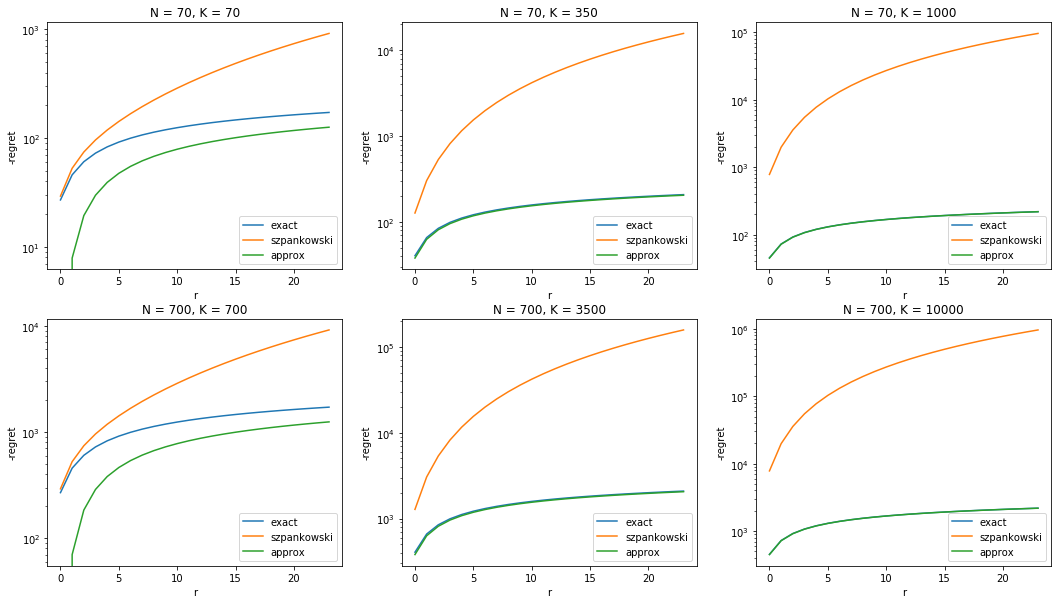

In [28]:
def plot_reg_r(n, m, ax):
    Y1 = [-ldiff(n, m, r) for r in range(2, 26)]
    Y2 = [-diff_szpankowski(n, m, r) for r in range(2, 26)]
    Y3 = [-diff_approx(n, m, r) for r in range(2, 26)]

    ax.plot(Y1, label='exact')
    ax.plot(Y2, label='szpankowski')
    ax.plot(Y3, label='approx')
    ax.set_title('N = %d, K = %d' % (n, m))
    ax.set_xlabel('r')
    ax.set_ylabel('-regret')
    ax.set_yscale('log')
    ax.legend(loc=4)

pylab.rcParams['figure.figsize'] = (18, 10)
fig, axs = subplots(2, 3)
plot_reg_r(70, 70, axs[0][0])
plot_reg_r(70, 350, axs[0][1])
plot_reg_r(70, 1000, axs[0][2])
plot_reg_r(700, 700, axs[1][0])
plot_reg_r(700, 3500, axs[1][1])
plot_reg_r(700, 10000, axs[1][2])
show()

This seems to be more appropriate for qNML as there $N$ is likely to be small and $K$ can be huge. In the paper the regret is given by
$$ d_{N, K} = h(z_0) - \log{\sqrt{\frac{h''(z_0)}{N}}} + O\left(\frac{h'''(z_0)}{(h''(z_0))^{3/2}} + \frac{1}{N}\right) $$

where

$$ h(z_0) = -K \log{\gamma_{N, K}} - (N + 1) (\log{(1 - \gamma_{N, K})} + \gamma_{N, K}) $$
$$ h''(z_0) = \frac{N+1}{(1 - \gamma_{N, K})^2 e^{2 \gamma_{N, K}}} \left[ \frac{2(N + 1)}{K} + \frac{1}{\gamma_{N, K}} \right] $$
$$ \gamma_{N, K} = \frac{K}{2 (N + 1)} \left( \sqrt{1 + \frac{4 (N + 1)}{K}} - 1 \right) $$

The square root in the $\gamma_{N, K}$ term is expanded using its Taylor series:

$$ \sqrt {1+x} = 1 + \frac{1}{2}x - \frac{1}{8}x^2 + \frac{1}{16} x^3 - \frac{5}{128} x^4 + \dots $$

As the Taylor series for $\sqrt{1 + x}$ is a good approximation only in the case $x < 1$, to achieve good approximation we should have $4(N + 1) / K$ < 1 i.e. $K > 4(N + 1)$. This can also be seen in the plots above. Thus maybe we could precompute exact values up to something like $4N$ or $5N$ and use approximation for values beyond that.

Let's still see if we can make the approximation more accurate by including more terms in the Taylor series than in the paper:

In [43]:
def new_approx(N, K, taylor_degree=3):
    taylor = sum((-1)**i * math.gamma(2 * i + 1) / ((1 - 2 * i) * math.gamma(i + 1)**2 * 4**i) * (4 * (N + 1) / K)**i
                 for i in range(1, taylor_degree))
    gamma = K / (2 * (N + 1)) * taylor
    h = - K * log(gamma) - (N + 1) * (log1p(-gamma) + gamma)
    hpp = log1p(N) - (2 * log1p(-gamma) + 2 * gamma) + log(2 * (N + 1) / K + 1 / gamma)
    return h - (hpp - log(N)) / 2

def new_approx_sympy(N, K, taylor_degree=3):
    i = sp.Symbol('i', nonnegative=True, integer=True)
    taylor = sp.summation((-1)**i * sp.factorial(2 * i) / ((1 - 2 * i) * sp.factorial(i)**2 * 4**i) * (4 * (N + 1) / K)**i,
                          (i, 0, taylor_degree - 1))
    gamma = K / (2 * (N + 1)) * taylor
    h = - K * sp.log(gamma) - (N + 1) * (sp.log(1 - gamma) + gamma)
    hpp = (N + 1) / ((1 - gamma)**2 * sp.exp(2 * gamma)) * (2 * (N + 1) / K + 1 / gamma)
    return h - sp.log(hpp / N) / 2

This seems to be more accurate when $N$ is closer to $K$:

In [30]:
logreg(1000, 5000)

In [31]:
approx(1000, 5000)

In [32]:
new_approx(1000, 5000, taylor_degree=4)

In [33]:
new_approx(1000, 5000, taylor_degree=5)

In [34]:
new_approx(1000, 5000, taylor_degree=6)

In [35]:
logreg(10, 50)

In [36]:
approx(10, 50)

In [37]:
new_approx(10, 50, taylor_degree=4)

In [38]:
new_approx(10, 50, taylor_degree=5)

In [ ]:
new_approx(10, 50, taylor_degree=6)

And when $K$ is big and $N$ is not very small:

In [39]:
logreg(1000, 100000)

In [40]:
approx(1000, 100000)

In [41]:
new_approx(1000, 100000, taylor_degree=5)

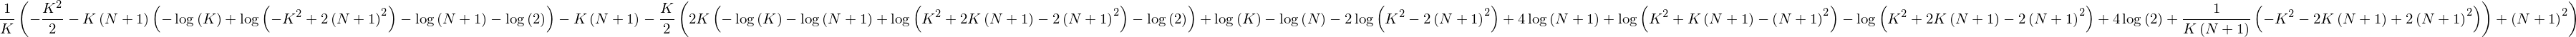

In [44]:
sp.expand_log(new_approx_sympy(N, K, taylor_degree=3).simplify(), force=True)